In [ ]:
!pip install sciann

In [ ]:
#Example
import numpy as np
from sciann import Variable, Functional, SciModel
from sciann.constraints import Data

# Synthetic data generated from sin function over [0, 2pi]
x_true = np.linspace(0, np.pi*2, 10000)
y_true = np.sin(x_true)

# The network inputs should be defined with Variable. 
x = Variable('x', dtype='float32')
# Each network is defined by Functional. The Functional class is designed to allow users 
#to design complex networks with a few lines of code.
y = Functional('y', x, [10, 10, 10], activation='tanh')
# The training data is a condition (constraint) on the model. =>outputs
c1 = Data(y)
# The model is formed with input `x` and condition `c1`.
model = SciModel(x, c1)

# Training: .solve runs the optimization and finds the parameters. 
model.train(x_true, y_true, batch_size=32, epochs=100)

# used to evaluate the model after the training. 
y_pred = model.predict(x_true)

# Burger Problem


The governing equation is: 
$$
  u_{,t} + u u_{,x} - (0.01 / \pi) u_{,xx} = 0, \quad t \in [0, 1], \quad x \in [-1,1]
$$
subjected to 
$$
u(t=0, x) = -\sin(\pi x), \quad u(t, x=\pm 1) = 0
$$

The objective is to solve this equation with PINN. 

##1. Setup Variable

In [7]:
x = sn.Variable('x')
t = sn.Variable('t')
u = sn.Functional('u', [t,x], 8*[20], 'tanh')

In [8]:
from numpy import pi
from sciann.utils.math import diff, sign, sin

Input variables are $(t, x)$ and targets are:

*   $L_1 : ~~ u_{,t} + u u_{,x} - (0.01 / \pi) u_{,xx}$

In [9]:
L1 = diff(u, t) + u*diff(u,x) - (0.01/pi)*diff(u, x, order=2)

In [10]:
TOL = 0.001
#Three Boundary conditions are:
C1 = (1-sign(t - TOL)) * (u + sin(pi*x))
C2 = (1-sign(x - (-1+TOL))) * (u)
C3 = (1+sign(x - ( 1-TOL))) * (u)

In [11]:
'''
parameter:
inputs = [x, t]
targets = [L1, C1, C2, C3]
'''
m = sn.SciModel([x, t], [L1, C1, C2, C3],plot_to_file='Model.png')

In [12]:
x_data, t_data = np.meshgrid(
    np.linspace(-1, 1, 100), 
    np.linspace(0, 1, 100)
)

##2. Training

In [28]:
h = m.train([x_data, t_data], 4*['zero'], learning_rate=0.002, epochs=1000, verbose=0)
#save model weights to the current path
model.save_weights('trained_Burger_Probelm.hdf5')


Total samples: 10000 
Batch size: 64 
Total batches: 157 


Epoch 00130: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.

Epoch 00495: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00838: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


Text(0, 0.5, 'loss')

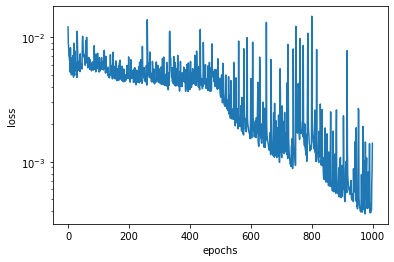

In [30]:
plt.semilogy(h.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')

##3.  Testing

In [15]:
x_test, t_test = np.meshgrid(
    np.linspace(-1, 1, 200), 
    np.linspace(0, 1, 200)
)
#prediction
u_pred = u.eval(m, [x_test, t_test])

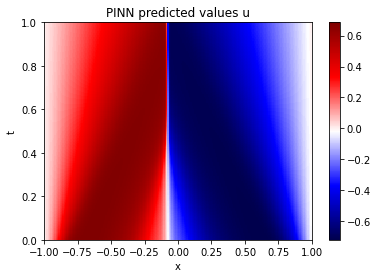

In [42]:
#pcolormesh is faster than pcolor
fig, ax = plt.subplots()
plt.xlabel('x')
plt.ylabel('t')
c = ax.pcolormesh(x_test,t_test,u_pred,cmap='seismic')
fig.colorbar(c, ax=ax)
plt.title("PINN predicted values u")
plt.savefig('Predicted_Figure.png')
plt.show()